# Lesson 6: Metaprompting with o1

Optimizing to production is one of the biggest painpoints we've seen developers experience with working with LLMs - with so much guidance for prompt engineering, RAG and fine-tuning out there, figuring out which optimization you need to hill-climb on your evals can be a difficult problem to frame and solve.

Luckily, it appears to be one of the use cases that `o1` is capable at. In this session we'll focus on how to use `o1-mini` to work with a set of evals to optimize our prompt for the task and improve score on our evals.


<div style="background-color:#fff6ff; padding:13px; border-width:3px; border-color:#efe6ef; border-style:solid; border-radius:6px">
<p> 💻 &nbsp; <b>Access <code>requirements.txt</code> and <code>helper.py</code> files:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Open"</em>.

<p> ⬇ &nbsp; <b>Download Notebooks:</b> 1) click on the <em>"File"</em> option on the top menu of the notebook and then 2) click on <em>"Download as"</em> and select <em>"Notebook (.ipynb)"</em>.</p>

<p> 📒 &nbsp; For more help, please see the <em>"Appendix – Tips, Help, and Download"</em> Lesson.</p>

</div>

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>Different Run Results:</b> The output generated by AI models can vary with each execution due to their dynamic, probabilistic nature. Don't be surprised if your results differ from those shown in the video.</p>

In [1]:
# Warning control
import warnings
warnings.filterwarnings('ignore')

# Import OpenAI key
from helper import get_openai_api_key
openai_api_key = get_openai_api_key()

In [2]:
from openai import OpenAI
from IPython.display import display, Markdown
import pandas as pd
from concurrent.futures import ThreadPoolExecutor
from functionDefinitions import TOOLS
import csv
import json
import os
import matplotlib.pyplot as plt

GPT_MODEL = 'gpt-4o-mini'
O1_MODEL = 'o1'

client = OpenAI(api_key=openai_api_key)

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


In [3]:
from redlines import Redlines
from IPython.display import display, Markdown

def compare_strings(string1, string2):
    # Create a Redlines object to compare the strings
    diff = Redlines(string1, string2)
    
    # Display the differences using Markdown
    display(Markdown(diff.output_markdown))

# Example usage
string_a = "This is the original text for comparison purposes."
string_b = "This is the modified text to compare for differences."

compare_strings(string_a, string_b)

This is the <span style='color:red;font-weight:700;text-decoration:line-through;'>original </span><span style='color:green;font-weight:700;'>modified </span>text <span style='color:green;font-weight:700;'>to compare </span>for <span style='color:red;font-weight:700;text-decoration:line-through;'>comparison purposes.</span><span style='color:green;font-weight:700;'>differences.</span>

## Step 1: Generate 4o routine (prompt)

We'll take the Flight Cancellation Policy that we have created and convert it to an LLM-based routine with the following prompt.

This process is also a good use of O1, using a purely text document to create instructions and tools for an LLM to make use of. To dive deeper on this topic check out [this cookbook](https://cookbook.openai.com/examples/o1/using_reasoning_for_routine_generation).

In [4]:
with open('originalPolicy/flightCancellationsPolicy.md', 'r') as file:
    flight_cancellation_policy = file.read()
    print(flight_cancellation_policy)

# **Internal Flight Cancellations and Changes Policy**

**Purpose**: This document serves as a detailed guide for internal support agents to handle flight cancellations and changes. The focus is on providing clear instructions, ensuring efficiency, consistency, and customer satisfaction during calls.

**Note**: Always maintain a calm, empathetic tone while assisting customers, especially during stressful situations involving cancellations or major changes.

## **Table of Contents**

1. General Guidelines for Handling Customer Requests  
2. Cancellations: Types and Policies  
3. Changes: Types and Policies  
4. Rebooking Guidelines  
5. Compensation and Refund Rules  
6. Special Cases  
7. FAQs for Common Scenarios

### **1\. General Guidelines for Handling Customer Requests**

* **Confirm Identity**: Verify the customer's identity by asking for their booking reference and any additional required details (e.g., name and flight number).  
* **Listen and Understand**: Clarify if the custo

In [5]:
CONVERSION_PROMPT = f"""
You are a helpful assistant tasked with taking an external facing help center article and converting it into a internal-facing programmatically executable routine optimized for an LLM. 
The LLM using this routine will be tasked with reading the policy, answering incoming questions from customers, and helping drive the case toward resolution.

Please follow these instructions:
1. **Review the customer service policy carefully** to ensure every step is accounted for. It is crucial not to skip any steps or policies.
2. **Organize the instructions into a logical, step-by-step order**, using the specified format. 
3. **Use the following format**:
   - **Main actions are numbered** (e.g., 1, 2, 3).
   - **Sub-actions are lettered** under their relevant main actions (e.g., 1a, 1b).
      **Sub-actions should start on new lines**
   - **Specify conditions using clear 'if...then...else' statements** (e.g., 'If the product was purchased within 30 days, then...').
   - **For instructions that require more information from the customer**, provide polite and professional prompts to ask for additional information.
   - **For actions that require data from external systems**, write a step to call a function using backticks for the function name (e.g., call the `check_delivery_date` function).
      - **If a step requires the customer service agent to take an action** (e.g., process a refund), generate a function call for this action (e.g., call the `process_refund` function).
      - **Only use the available set of functions that are defined below.
   - **If there is an action an assistant can perform on behalf of the user**, include a function call for this action (e.g., call the `change_email_address` function), and ensure the function is defined with its purpose and required parameters.
      - **Only use the available set of functions that are defined below.
   - **The step prior to case resolution should always be to ask if there is anything more you can assist with**.
   - **End with a final action for case resolution**: calling the `case_resolution` function should always be the final step.
4. **Ensure compliance** by making sure all steps adhere to company policies, privacy regulations, and legal requirements.
5. **Handle exceptions or escalations** by specifying steps for scenarios that fall outside the standard policy.
6. **Ensure coverage** by checking that all of the conditions covered in the policy are also covered in the routines

**Important**: Always wrap the functions you return in backticks i.e. `check_ticket_type`. Do not include the arguments to the functions.

Here are the currently available set of functions in JSON format: 
TOOLS: {TOOLS}

Please convert the following customer service policy into the formatted routine, ensuring it is easy to follow and execute programmatically. Ensure that you **only** use the functions provided and do **not** create net new functions."""

In [6]:
def generate_routine(policy):
    try:
        messages = [
            {
                "role": "user",
                "content": f"""
                    {CONVERSION_PROMPT}

                    POLICY:
                    {policy}
                """
            }
        ]

        response = client.chat.completions.create(
            model='o1-mini',
            messages=messages
        )
        

        return response.choices[0].message.content 
    except Exception as e:
        print(f"An error occurred: {e}")

In [7]:
flight_cancellation_routine = generate_routine(flight_cancellation_policy)

In [8]:
display(Markdown(flight_cancellation_routine))

```markdown
1. **Verify Customer Identity**
   a. Call the `verify_identity` function.

2. **Understand Customer Request**
   a. Call the `ask_clarification` function with the prompt: "Are you looking to cancel your flight, make changes to your booking, or inquire about compensation?"

3. **Check Ticket Type**
   a. Call the `check_ticket_type` function.

4. **Handle Cancellation Requests**
   a. If the customer initiated the cancellation, then:
      i. If the ticket is refundable, then:
         - If the cancellation is within 24 hours of booking, call the `process_full_refund` function.
         - Else, call the `check_fare_rules` function.
            - Based on fare rules, if a partial refund is applicable, call the `process_partial_refund` function.
            - Else, call the `process_full_refund` function.
      ii. Else if the ticket is non-refundable, then:
         - Call the `offer_flight_credit` function.
         - Inform the customer about any applicable penalty fees.
   b. Else if the airline initiated the cancellation, then:
      i. If the cancellation is weather-related, then:
         - Call the `rebook_without_fee` function.
         - If rebooking is not acceptable to the customer, then call the `process_full_refund` function.
      ii. Else if the cancellation is due to mechanical issues or operational changes, then:
         - Call the `prioritize_missed_connections` function.
         - If an overnight stay is required, call the `offer_accommodation` function.
   c. Else if the customer is a no-show, then:
      i. If the ticket is refundable, then:
         - Call the `process_partial_refund` function for applicable taxes or fees.
      ii. Else, inform the customer that no refund is available but offer travel credits if applicable.

5. **Handle Change Requests**
   a. If the customer initiated the change, then:
      i. If the change is same-day, then:
         - If the ticket is flexible, call the `process_change_no_fee` function.
         - Else, call the `apply_change_fee` function and inform the customer of any fare differences.
      ii. Else if the change is in advance, then:
         - If the change is within 7 days of departure, call the `apply_change_fee` function.
         - Else, call the `apply_lesser_change_fee` function based on ticket type.
   b. Else if the airline initiated the change, then:
      i. If the schedule change is minor (less than 2 hours), then:
         - Inform the customer of the new schedule.
         - Offer alternative options by calling the `provide_alternative_options` function if requested.
      ii. Else if the schedule change is major (2+ hours), then:
         - Offer options to rebook by calling the `rebook_without_fee` function.
         - Offer a full refund by calling the `process_full_refund` function.
         - Offer travel credits by calling the `offer_flight_credit` function.

6. **Rebooking Guidelines**
   a. Call the `check_next_available_flight` function to find the next available flight.
   b. If no suitable options are available, then:
      i. Call the `check_interline_partners` function.
      ii. Call the `book_interline_flight` function if an interline partner flight is available.
   c. If a higher class is available without economy seats, then call the `offer_available_upgrades` function.

7. **Compensation and Refund Processing**
   a. If a refund is to be processed, then:
      i. Inform the customer of the refund timeline.
      ii. Call the `determine_refund_method` function.
         - If refund to the original payment method, then call the `process_refund` function.
         - Else, call the `apply_travel_credit` function with the appropriate bonus percentage.
   b. If compensation is applicable, then:
      i. Call the `check_compensation_eligibility` function.
      ii. If eligible, provide meal vouchers or hotel accommodation as needed.

8. **Handle Special Cases**
   a. If the request is due to a medical emergency, then:
      i. Call the `process_flexible_cancellation` function with the medical certificate.
      ii. Or, call the `waive_change_fees` function with the provided documentation.
   b. If the request is for bereavement, then:
      i. Call the `apply_bereavement_flexibility` function with the bereavement documentation.
   c. If the booking is a group booking, then:
      i. Call the `process_partial_group_cancellation` function if individual cancellations are requested.
      ii. If a name change is requested, then call the `permit_name_change` function.
   d. If the booking involves unaccompanied minors, then:
      i. Call the `arrange_supervision` function for any flight changes.
      ii. Call the `prioritize_minors_rebooking` function to ensure priority rebooking.

9. **Handle FAQs for Common Scenarios**
   a. If the customer asks about connecting flights being affected, then:
      - Call the `prioritize_missed_connections` function.
   b. If the customer seeks upgrades after a cancellation, then:
      - Call the `offer_available_upgrades` function.
      - If upgrades are not available, inform the customer about fare differences.
   c. If the customer needs to change the destination, then:
      - Call the `process_destination_change` function.
      - Inform the customer of any applicable fare differences and change fees.
   d. If the booking is with a third party, then:
      - Call the `assist_third_party_booking` function.
   e. If the customer requests compensation for inconvenience, then:
      - Call the `assess_compensation_request` function.
      - Inform the customer of available compensation options based on eligibility.
   f. If the preferred flight is fully booked, then:
      - Call the `check_next_available_flight` function.
      - Offer to waitlist by calling the `book_flight` function if possible.
      - Call the `offer_available_upgrades` function if an upgrade is available.

10. **Finalize Case Resolution**
    a. Ask the customer: "Is there anything else I can assist you with?"
    b. Call the `case_resolution` function.
```

### Data quality check

We'll check that `o1-mini` has followed our instructions and used only the functions we provided.

If it added additional ones, we'll need to write functions for them before proceeding.

In [9]:
import re
from collections import Counter

def compare_lists(a, b):
    # Create Counters for both lists
    counter_a = Counter(a)
    counter_b = Counter(b)
    
    # Find elements that are only in A or have a higher count in A
    diff_a = counter_a - counter_b
    # Find elements that are only in B or have a higher count in B
    diff_b = counter_b - counter_a
    
    # Report differences
    print("Items in A that are not in B (or more of in A):")
    for item, count in diff_a.items():
        print(f"{item}: {count}")

    print("\nItems in B that are not in A (or more of in B):")
    for item, count in diff_b.items():
        print(f"{item}: {count}")

def extract_function_names(text):
    # Use regex to match text between backticks and extract function names
    pattern = r'`(.*?)`'
    matches = re.findall(pattern, text)
    return matches

# Extract a unique list of the functions in the generated routine
function_names_from_o1 = set(extract_function_names(flight_cancellation_routine))

# Extract the list of TOOLs we provided the model
function_names_defined = [tool["function"]["name"] for tool in TOOLS if tool["type"] == "function"]

# Print the differences
## Items that are in A and not in B need functions written for them
## Items that are in B and not in A are fine, they are just unused in the routine the model has written
compare_lists(function_names_from_o1, function_names_defined)

Items in A that are not in B (or more of in A):
: 1

Items in B that are not in A (or more of in B):


## Step 2: Evaluation

Now that we have a routine generated with o1, we can run it against our evaluation suite and measure its accuracy.

We'll start by creating an agent that is equipped with the policy and a list of tools. It will be given messages from an existing conversation and will be tasked with determining the next best action to take

In [10]:
def agent_response(transcript, policy, model):
    try:
        messages = [
            {
                "role": "system",
                "content": f"""
You are a customer service agent that is responsible for handling airline related issues. Below is the exact policy that you must follow to address the customer's issue.

POLICY:
{policy}
                """
            }
        ]

        messages.extend(transcript)
        response = client.chat.completions.create(
            model=model,
            messages=messages,
            tools=TOOLS,
            parallel_tool_calls=False,
        temperature=0)
        
        return response.choices[0].message 
    except Exception as e:
        print(f"An error occurred: {e}")
        print(messages)

We will process each row in parallel to reduce runtime and compare the function call + inputs that the model selects against our expected function + parameters.

In [11]:
import math 

def safe_str(value):
    return "" if (isinstance(value, float) and math.isnan(value)) else str(value)

def process_row(row_number,test_row,policy,model,iteration=0, verbose=False):
    # Extract variables from test_row
    context = test_row['context']
    request = test_row['request']
    full_name = test_row['full_name']
    booking_ref = test_row['booking_ref']
    flight_no = test_row['flight_no']
    ticket_type = test_row['ticket_type']
    fare_rules = safe_str(test_row['fare_rules'])
    medical_certificate = safe_str(test_row['medical_certificate'])
    refund_amount = safe_str(test_row['refund_amount'])
    expected_function = test_row['expected_function']
    expected_inputs_str = test_row['expected_inputs']
    expected_inputs = json.loads(expected_inputs_str)

    CUSTOMER_PROMPT = f"""<objective>You are a customer named {full_name} trying to resolve an issue with a customer service agent.
    Continue providing the information the agent requests so they can solve your issue.
    If you have the information in your *details* then use that. Otherwise, generate an appropriate answer.</objective>
    <details>
    Booking Reference: {booking_ref}
    Flight Number: {flight_no}
    {f"Medical Reference: {medical_certificate}" if medical_certificate else ""}
    Context: {context}
    Your initial request: {request}
    </details>
    <guidance>
    Remember that YOU are the customer.
    If the agent needs some information, that must come from you. 
    Do not ask the agent for information.
    </guidance>
    """

    # Initialize transcript
    transcript = [{"role": "user", "content": request}]
    if verbose:
        print(f'Starting request: {request}')
    
    # Initialize variables
    is_correct = False

    loop_count = 0
    while True:
        loop_count += 1
        if loop_count > 10:
            actual_function = None
            actual_inputs = None
            break
        # Call agent_response with the current transcript, policy, model
        response = agent_response(transcript, policy, GPT_MODEL)
        
        # Extract assistant message content and tool_calls
        if response:
            assistant_message_content = response.content
            tool_calls = response.tool_calls
        else:
            assistant_message_content = None
            tool_calls = None
        
        if not tool_calls:
            # Append assistant's message to transcript
            transcript.append({"role": "assistant", "content": assistant_message_content})
            
            # Get customer response
            customer_messages = [{"role": "system", "content": CUSTOMER_PROMPT}]
            customer_messages.extend(transcript)
            
            customer_response = client.chat.completions.create(model=GPT_MODEL, messages=customer_messages)
            
            # Append customer response to transcript
            transcript.append({"role": "user", "content": customer_response.choices[0].message.content})
            
            # Continue the loop
            continue
        else:
            #print(tool_calls)
            # There is a tool call
            tool_call = tool_calls[0]  # Assuming we're only interested in the first tool call
            function_name = tool_call.function.name
            arguments = json.loads(tool_call.function.arguments)
            
            if function_name == 'verify_identity':
                # Append assistant's message to transcript
                transcript.append(response)
                
                # Simulate the tool response
                tool_response = "True"
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'ask_clarification':
                # Take the 'prompt' from arguments and use it as assistant message
                clarification_prompt = arguments.get('prompt')
                
                # Append assistant's clarification message
                transcript.append({"role": "assistant", "content": clarification_prompt})
                
                # Get customer response
                customer_messages = [{"role": "system", "content": CUSTOMER_PROMPT}]
                customer_messages.extend(transcript)
                
                customer_response = client.chat.completions.create(model=GPT_MODEL, messages=customer_messages)
                
                # Append customer response to transcript
                transcript.append({"role": "user", "content": customer_response.choices[0].message.content})
                
                # Continue the loop
                continue
            elif function_name == 'check_ticket_type':
                # Append assistant's message to transcript
                transcript.append(response)
                
                tool_response = f'Ticket type: {ticket_type}\nFare rules: {fare_rules}'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'check_fare_rules':
                # Append assistant's message to transcript
                transcript.append(response)
                
                tool_response = f'Ticket type: {ticket_type}\nFare rules: {fare_rules}'

                if fare_rules == 'partial_refund':
                    tool_response += f'\nRefund amount: {refund_amount}'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'get_refund_amount':
                # Append assistant's message to transcript
                transcript.append(response)
                
                tool_response = f'Refund amount: {refund_amount}'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'check_next_available_flight':
                # Append assistant's message to transcript
                transcript.append(response)
                
                # simulating the tool response
                tool_response = f'Next available flight: LMG091 at 10:00 AM Tomorrow'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            elif function_name == 'provide_alternative_options':
                # Append assistant's message to transcript
                transcript.append(response)
                
                # simulating the tool response
                tool_response = f'Next available flight: FR9876 at 5:00 PM Tomorrow'
                
                # Append the tool response to transcript
                transcript.append({"role": "tool", "content": tool_response, "tool_call_id": tool_call.id})
                
                # Continue the loop
                continue
            else:
                if verbose:
                    print('Got a successful function call')
                # Stop and compare function call and arguments with expected_function and expected_inputs
                transcript.append(response)
                actual_function = function_name
                actual_inputs = arguments
                is_correct = (actual_function == expected_function) and (str(actual_inputs) == str(expected_inputs))
                
                # Break the loop
                break
    
    # Return the results
    return {
        'request': request,
        'context': context,
        'expected_function': expected_function,
        'expected_inputs': expected_inputs,
        'actual_function': actual_function,
        'actual_inputs': actual_inputs,
        'is_correct': is_correct,
        'transcript': transcript
    }

# added post-filming to address transcript size
def filter_messages(message_list):
    messages = []
    for item in message_list:
        # Convert the item to a string and check if 'ChatCompletionMessage' is in it.
        if 'ChatCompletionMessage' in str(item):
            #print(item)
            message = {"role": "assistant",
                       "tool_call": {
                           "name": item.tool_calls[0].function.name,
                           "arguments": item.tool_calls[0].function.arguments
                       }
                      }
            messages.append(message)
        else:
            messages.append(item)
    return messages


def evaluate_function_calls(df, policy, model, i=0, verbose=False):
    records = []

    # Use ThreadPoolExecutor to process rows in parallel
    with ThreadPoolExecutor() as executor:
        futures = {executor.submit(process_row, row_number, row, policy, model, i, verbose): row_number for row_number, row in df.iterrows()}
        for future in futures:
            record = future.result()
            records.append(record)


    df = pd.DataFrame(records)
    df['cleaned_transcript'] = df['transcript'].apply(filter_messages)
    total_accuracy = df['is_correct'].mean()
    return df, total_accuracy

Let's take a look at the results

In [12]:
eval_df = pd.read_csv('evals/policyEvals.csv')
eval_df.head()

,ID,context,request,full_name,booking_ref,flight_no,expected_function,expected_inputs,ticket_type,fare_rules,medical_certificate,refund_amount
0,0,I want to cancel my flight as I am initiating the cancellation myself.,"I would like to cancel my flight, please.",John Doe,ABC123,XYZ789,process_partial_refund,"{""booking_reference"":""ABC123"",""refund_amount"":198}",refundable,partial_refund,NaN,198.0
1,1,I want to change my flight to a different date.,I'd like to initiate a change to my flight for a later date.,Jane Smith,DEF456,XYZ123,apply_change_fee,"{""booking_reference"":""DEF456""}",nonrefundable,NaN,NaN,NaN
2,2,I want to request a refund because my flight was canceled by the airline due to weather.,"My flight was canceled by the airline, and I want a refund.",Emma Johnson,GHI789,ABC123,process_full_refund,"{""booking_reference"":""GHI789""}",refundable,full_refund,NaN,NaN
3,3,I want to cancel my flight but I think it is non-refundable.,I want to cancel my non-refundable ticket.,Michael Brown,JKL012,DEF456,offer_flight_credit,"{""booking_reference"":""JKL012""}",nonrefundable,NaN,NaN,NaN
4,4,I want to cancel my flight and I believe it is refundable.,I want to cancel my refundable ticket.,Sarah Brown,MNO345,STU678,process_partial_refund,"{""booking_reference"":""MNO345"",""refund_amount"":65}",refundable,partial_refund,NaN,65.0


In [13]:
from termcolor import colored

def display_row(index):
    eval_row = eval_df.iloc[index]
    df_row = df.iloc[index][["actual_function", "actual_inputs", "is_correct", "cleaned_transcript"]]
    transcript_list = df_row["cleaned_transcript"]

    print("Eval DataFrame Row:")
    print(eval_row)
    print("\nDataFrame Columns:")
    print("actual_function:", df_row["actual_function"])
    print("actual_inputs:", df_row["actual_inputs"])
    print("is_correct:", df_row["is_correct"])
    print("transcript:")
    for entry in transcript_list:
        role = entry["role"] if isinstance(entry, dict) else getattr(entry, "role", None)
        color = "blue" if role == "user" else "red"
        print(colored(str(entry), color))


In [14]:
df, accuracy = evaluate_function_calls(eval_df, flight_cancellation_routine, GPT_MODEL)

# Display the accuracy as a mini header
display(Markdown(f"### Accuracy: {accuracy:.2%}"))

display(df)

### Accuracy: 35.29%

,request,context,expected_function,expected_inputs,actual_function,actual_inputs,is_correct,transcript,cleaned_transcript
0,"I would like to cancel my flight, please.",I want to cancel my flight as I am initiating the cancellation myself.,process_partial_refund,"{'booking_reference': 'ABC123', 'refund_amount': 198}",process_partial_refund,"{'booking_reference': 'ABC123', 'refund_amount': 198.0}",False,"[{'role': 'user', 'content': 'I would like to cancel my flight, please.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_QvoAALb1GdJmjtc9sqAE3pj1', function=Function(arguments='{""booking_reference"":""ABC123"",""full_name"":""John Doe"",""flight_number"":""XY123""}', name='verify_identity'), type='function')]), {'role': 'tool', 'content': 'True', 'tool_call_id': 'call_QvoAALb1GdJmjtc9sqAE3pj1'}, {'role': 'assistant', 'content': 'Are you looking to cancel your flight, make changes to your booking, or inquire about compensation?'}, {'role': 'user', 'content': 'I would like to cancel my flight.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_vueS77cOEKOtDcuYXq9ajzGb', function=Function(arguments='{""booking_reference"":""ABC123""}', name='check_ticket_type'), type='function')]), {'role': 'tool', 'content': 'Ticket type: refundable Fare rules: partial_refund', 'tool_call_id': 'call_vueS77cOEKOtDcuYXq9ajzGb'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_amz0vrd4S9MRtCx3xIU3UbNB', function=Function(arguments='{""booking_reference"":""ABC123""}', name='check_fare_rules'), type='function')]), {'role': 'tool', 'content': 'Ticket type: refundable Fare rules: partial_refund Refund amount: 198.0', 'tool_call_id': 'call_amz0vrd4S9MRtCx3xIU3UbNB'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_IfciS8ovmKwKJWXwu8slkEd9', function=Function(arguments='{""booking_reference"":""ABC123"",""refund_amount"":198.0}', name='process_partial_refund'), type='function')])]","[{'role': 'user', 'content': 'I would like to cancel my flight, please.'}, {'role': 'assistant', 'tool_call': {'name': 'verify_identity', 'arguments': '{""booking_reference"":""ABC123"",""full_name"":""John Doe"",""flight_number"":""XY123""}'}}, {'role': 'tool', 'content': 'True', 'tool_call_id': 'call_QvoAALb1GdJmjtc9sqAE3pj1'}, {'role': 'assistant', 'content': 'Are you looking to cancel your flight, make changes to your booking, or inquire about compensation?'}, {'role': 'user', 'content': 'I would like to cancel my flight.'}, {'role': 'assistant', 'tool_call': {'name': 'check_ticket_type', 'arguments': '{""booking_reference"":""ABC123""}'}}, {'role': 'tool', 'content': 'Ticket type: refundable Fare rules: partial_refund', 'tool_call_id': 'call_vueS77cOEKOtDcuYXq9ajzGb'}, {'role': 'assistant', 'tool_call': {'name': 'check_fare_rules', 'arguments': '{""booking_reference"":""ABC123""}'}}, {'role': 'tool', 'content': 'Ticket type: refundable Fare rules: partial_refund Refund amount: 198.0', 'tool_call_id': 'call_amz0vrd4S9MRtCx3xIU3UbNB'}, {'role': 'assistant', 'tool_call': {'name': 'process_partial_refund', 'arguments': '{""booking_reference"":""ABC123"",""refund_amount"":198.0}'}}]"
1,I'd like to initiate a change to my flight for a later date.,I want to change my flight to a different date.,apply_change_fee,{'booking_reference': 'DEF456'},apply_change_fee,{'booking_reference': 'DEF456'},True,"[{'role': 'user', 'content': 'I'd like to initiate a change to my flight for a later date.'}, {'role': 'assistant', 'content': 'Are you looking to cancel your flight, make changes to your booking, or inquire about compensation?'}, {'role': 'user', 'content': 'I would like to chan

In [15]:
display_row(8)

Eval DataFrame Row:
ID                                                                                 8
context                       I want to cancel my flight due to a medical emergency.
request                   I want to cancel my flight because of a medical emergency.
full_name                                                                Laura Adams
booking_ref                                                                   YZA567
flight_no                                                                     PQR678
expected_function                                      process_flexible_cancellation
expected_inputs        {"booking_reference":"YZA567","medical_certificate":"MC1234"}
ticket_type                                                                 flexible
fare_rules                                                                       NaN
medical_certificate                                                           MC1234
refund_amount                                

## Step 3: Improve 4o routine

Let's now leverage o1 again to add in a metaprompting loop to see if we can improve the quality of our evals.

We'll take the following multi-step approach:
- We'll pass in the current routine + eval results to o1 and ask it analyze the results and update the routine accordingly
- Since o1 does not currently support structured outputs, we'll chain with output with a 4o to enforce a schema we can parse
- Finally, we take the new routine and run it back through our eval to generate new results

We'll run this loop a fixed number of times and see what improvements we can make

In [16]:
def get_openai_response(messages, model, response_format=None):
    try:
        if response_format:
            response = client.chat.completions.create(
                model=model,
                messages=messages,
                response_format={"type": "json_schema", "json_schema": response_format}
            )
        else:
            response = client.chat.completions.create(
                model=model,
                messages=messages
            )
        return response.choices[0].message.content
    except Exception as e:
        print(f"An error occurred: {e}")


OUTPUT_SCHEMA = {
                    "name": "policy_output",
                    "schema": {
                    "type": "object",
                    "properties": {
                        "final_answer": { "type": "string" }
                    },
                    "required": ["final_answer"],
                    "additionalProperties": False
                    },
                    "strict": True
                }

In [17]:
start_o1_message = [
    {
        "role": "user",
        "content": f"""# Instructions
You are an agent that is responsible for improving the quality of instructions that are provided to a customer service LLM agent. 
Your task is to improve the instructions that are provided to the LLM agent in order to increase accuracy on a test set while adhering to the initial policy. 

## Criteria
- Analyze the existing instructions and the results of the eval. Understand which behaviors lead to failures.
- For example, if the LLM agent is not asking for the booking reference when it is needed, you should add a step to ask for the booking reference.
- Improve the instructions to address the gaps in the eval results.
- Ensure changes made are compliant with the original policy.
- Only use the tools provided.
- Use the functions provided to the best of your ability to ensure the LLM agent can handle the customer service requests effectively. Including gathering data where necessary.
- Try changing the format if this formatting doesn't work well - consider basic XML (e.g. <step> <substep> <if> <case>) or markdown as alternatives.

You will be provided with 4 items:
1) The ground-truth policy for the customer service agent containing detailed instructions on how to handle flight cancellations and changes.
2) Full list of available functions.
3) A routine instruction set.
4) A results that shows the LLMs performance on a test set using this routine instruction set. This dataset contains columns showing:
    - request: This is the initial user request. 
    - expected_function: This is the function we expect the LLM to call at the end of the conversation. 
    - expected_input: This is the input we expect the LLM to provide to the function at the end of the conversation.
    - actual_function: This is the final function the LLM called using the current instructions.
    - actual_input: These are the function parameters the LLM provided based on the current instructions.
    - transcript: This is the conversation transcript between the user and the LLM agent. 
    - is_correct: True/False value depending on if the model responded correctly

You may be provided with a history of edits and evaluations. You can use this information to understand what has been tried before and what has worked or not worked.

# Data

## 1. Original policy
{flight_cancellation_policy}

## 2. Functions
{TOOLS}

# Conclusion

Return the improved policy exactly as written within the defined JSON. Remove all parts from the LLM's answer that are not part of the policy, and do not create additional keys.
"""
     }
]

In [18]:
import tiktoken 

encoding = tiktoken.get_encoding("o200k_base")

def num_tokens_from_messages(messages):
    entire_input = ""
    for message in messages:
        entire_input += message["content"] + " "
    tokens = encoding.encode(entire_input)
    return len(tokens)

When improving the routine, consider these approaches:
- Adding synthetic examples to show the model how to choose between two commonly mistaken functions
- Given it general guidance on what attributes to look out for which it commonly mislabels
- Being more specific with your guidance on how to follow the routine.

<p style="background-color:#f7fff8; padding:15px; border-width:3px; border-color:#e0f0e0; border-style:solid; border-radius:6px"> 🚨
&nbsp; <b>High Token Warning!:</b> Running the following cell consumes many tokens. Running multiple times may result in a message regarding exceeding a monthy quota.</p>

In [19]:
# start with data from first run
routines = [flight_cancellation_routine]
results = [df]
accuracies = [round(accuracy * 100, 2)]
o1_messages = start_o1_message.copy()

MAX_TOKENS = 120000

for i in range(3):
    display(Markdown(f"## Iteration {i+1}"))
    
    # Build a candidate message with the most recent eval (full table)
    prev_results = results[-1]
    pf = prev_results.drop(columns=['transcript'])

    new_eval_content = (
        f"## 3. Routine instructions:\n"
        f"{routines[-1]}\n"
        f"## 4. Results table:\n"
        f"{pf.to_json(orient='records')}\n"
    )
    
    # Check token count before adding the newest eval
    candidate_messages = o1_messages + [{"role": "user", "content": new_eval_content}]
    if num_tokens_from_messages(candidate_messages) <= MAX_TOKENS:
        o1_messages.append({"role":"user", "content": new_eval_content})
    else:
        # If we can't even fit the newest eval, consider truncation or error handling
        # For simplicity, we skip truncation logic here
        print("excluding eval content {num_tokens_from_messages(candidate_messages)}")
        pass

    print(f"num tokens {num_tokens_from_messages(o1_messages)}")
    print(f"len messages {len(o1_messages)}")


    # Get the updated routine from the metaprompting assistant
    temp_routine_json = get_openai_response(o1_messages
                                            , O1_MODEL
                                            ,response_format=OUTPUT_SCHEMA)
    #temp_routine_str = temp_routine_json.strip("json```").strip("```")
    new_routine = json.loads(temp_routine_json)["final_answer"]
    routines.append(new_routine)

    eval_df = pd.read_csv('evals/policyEvals.csv')

    # Evaluate the function calls with the current policy on the gpt-4o model
    eval_df, accuracy = evaluate_function_calls(
        eval_df,
        new_routine,
        GPT_MODEL,
        i
    )
    accuracies.append(round(accuracy * 100, 2))
    results.append(eval_df)
    display(Markdown(f"### Accuracy: {accuracy:.2%}"))

    #list the IDs of the failed rows
    failed_ids = eval_df[eval_df['is_correct'] == False].index.tolist()
    display(eval_df.loc[failed_ids])
    eval_df.to_csv(f'evals/results_run_{i+1}.csv', index=False)

    # Instantiate fresh o1 message
    o1_messages = start_o1_message.copy()

    # Attempt to include older examples (omitting 'transcript') within token limit
    older_results = results[:-1][::-1]  # all except the newest, reversed for most recent first
    for old_eval_df in older_results:
        if 'transcript' in old_eval_df.columns:
            truncated_df = old_eval_df.drop(columns=['transcript','cleaned_transcript'])
        else:
            truncated_df = old_eval_df

        old_content = "## Older eval (no transcript):\n" + truncated_df.to_json(orient='records')
        candidate_messages = o1_messages + [{"role": "user", "content": old_content}]
        if num_tokens_from_messages(candidate_messages) <= MAX_TOKENS:
            o1_messages.append({"role": "user", "content": old_content})
        else:
            # If we exceed token limits, stop adding older examples
            break


## Iteration 1

num tokens 11135
len messages 2


### Accuracy: 94.12%

,request,context,expected_function,expected_inputs,actual_function,actual_inputs,is_correct,transcript,cleaned_transcript
11,I need to change my flight within the next 7 days.,I want to change my flight because it's within the next week and I hope I can do it without any extra fees.,process_change_no_fee,"{'booking_reference': 'GHI123', 'new_flight': 'LMG091'}",process_change_no_fee,{'booking_reference': 'GHI123'},False,"[{'role': 'user', 'content': 'I need to change my flight within the next 7 days.'}, {'role': 'assistant', 'content': 'Could you please provide me with your booking reference, full name, and flight number? This information is necessary to assist you further.'}, {'role': 'user', 'content': 'Sure! My booking reference is GHI123, my full name is Lisa Brown, and my flight number is PQR789.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_wKhWsXT2bhCO2LV2bduppkZX', function=Function(arguments='{""booking_reference"":""GHI123"",""full_name"":""Lisa Brown"",""flight_number"":""PQR789""}', name='verify_identity'), type='function')]), {'role': 'tool', 'content': 'True', 'tool_call_id': 'call_wKhWsXT2bhCO2LV2bduppkZX'}, {'role': 'assistant', 'content': 'Thank you for verifying your identity, Lisa. Are you looking to cancel your flight, make changes to your booking, or inquire about compensation?'}, {'role': 'user', 'content': 'I'm looking to change my flight. I want to know if I can do that without incurring any extra fees since it's within the next week.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_u6MQRrthHWPKch6H5oPtmXE3', function=Function(arguments='{""booking_reference"":""GHI123""}', name='check_ticket_type'), type='function')]), {'role': 'tool', 'content': 'Ticket type: flexible Fare rules: ', 'tool_call_id': 'call_u6MQRrthHWPKch6H5oPtmXE3'}, {'role': 'assistant', 'content': 'Since you have a flexible ticket, you can change your flight without incurring any extra fees. Please provide me with the details of the new flight you would like to book.'}, {'role': 'user', 'content': 'I'm looking to change my flight details to a later date on the same route. I don't have the specific date or time yet, but I would prefer a flight in the afternoon if possible. '}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_FC2BUggQzAxiuyQsx0fWj6dw', function=Function(arguments='{""booking_reference"":""GHI123""}', name='process_change_no_fee'), type='function')])]","[{'role': 'user', 'content': 'I need to change my flight within the next 7 days.'}, {'role': 'assistant', 'content': 'Could you please provide me with your booking reference, full name, and flight number? This information is necessary to assist you further.'}, {'role': 'user', 'content': 'Sure! My booking reference is GHI123, my full name is Lisa Brown, and my flight number is PQR789.'}, {'role': 'assistant', 'tool_call': {'name': 'verify_identity', 'arguments': '{""booking_reference"":""GHI123"",""full_name"":""Lisa Brown"",""flight_number"":""PQR789""}'}}, {'role': 'tool', 'content': 'True', 'tool_call_id': 'call_wKhWsXT2bhCO2LV2bduppkZX'}, {'role': 'assistant', 'content': 'Thank you for verifying your identity, Lisa. Are you looking to cancel your flight, make changes to your booking, or inquire about compensation?'}, {'role': 'user', 'content': 'I'm looking to change my flight. I want to know if I can do that without incurring any extra fees since it's within the next week.'}, {'role': 'assistant', 'tool_call': {'name': 'check_ticket_type', 'arguments': '{""booking_reference"":""GHI123""}'}}, {'role': 'tool', 'content': 'Ticket type: flexible Fare rules: ', 'tool_call_id': 'call_u6MQRrthHWPKch6H5oPtmXE3'}, {'role': 'assistant', 'content': 'Since you have a fl

## Iteration 2

num tokens 15467
len messages 3


### Accuracy: 82.35%

,request,context,expected_function,expected_inputs,actual_function,actual_inputs,is_correct,transcript,cleaned_transcript
2,"My flight was canceled by the airline, and I want a refund.",I want to request a refund because my flight was canceled by the airline due to weather.,process_full_refund,{'booking_reference': 'GHI789'},rebook_without_fee,{'booking_reference': 'GHI789'},False,"[{'role': 'user', 'content': 'My flight was canceled by the airline, and I want a refund.'}, {'role': 'assistant', 'content': 'To assist you with your refund request, I need to verify your identity. Please provide me with the following details: 1. Your booking reference 2. Your full name 3. Your flight number Once I have this information, I can proceed with your request.'}, {'role': 'user', 'content': 'My booking reference is GHI789, my full name is Emma Johnson, and my flight number is ABC123.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_sYauYJ1B5uHjx2T0gvvh1kQR', function=Function(arguments='{""booking_reference"":""GHI789"",""full_name"":""Emma Johnson"",""flight_number"":""ABC123""}', name='verify_identity'), type='function')]), {'role': 'tool', 'content': 'True', 'tool_call_id': 'call_sYauYJ1B5uHjx2T0gvvh1kQR'}, {'role': 'assistant', 'content': 'Thank you for verifying your identity, Emma Johnson. Since your flight was canceled by the airline, I need to check the reason for the cancellation to proceed with your refund request. Are you aware if the cancellation was due to weather-related issues or mechanical/operational issues?'}, {'role': 'user', 'content': 'Yes, the cancellation was due to weather-related issues.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_rmdpnoP6YeSVWg370NcOeqAW', function=Function(arguments='{""booking_reference"":""GHI789""}', name='rebook_without_fee'), type='function')])]","[{'role': 'user', 'content': 'My flight was canceled by the airline, and I want a refund.'}, {'role': 'assistant', 'content': 'To assist you with your refund request, I need to verify your identity. Please provide me with the following details: 1. Your booking reference 2. Your full name 3. Your flight number Once I have this information, I can proceed with your request.'}, {'role': 'user', 'content': 'My booking reference is GHI789, my full name is Emma Johnson, and my flight number is ABC123.'}, {'role': 'assistant', 'tool_call': {'name': 'verify_identity', 'arguments': '{""booking_reference"":""GHI789"",""full_name"":""Emma Johnson"",""flight_number"":""ABC123""}'}}, {'role': 'tool', 'content': 'True', 'tool_call_id': 'call_sYauYJ1B5uHjx2T0gvvh1kQR'}, {'role': 'assistant', 'content': 'Thank you for verifying your identity, Emma Johnson. Since your flight was canceled by the airline, I need to check the reason for the cancellation to proceed with your refund request. Are you aware if the cancellation was due to weather-related issues or mechanical/operational issues?'}, {'role': 'user', 'content': 'Yes, the cancellation was due to weather-related issues.'}, {'role': 'assistant', 'tool_call': {'name': 'rebook_without_fee', 'arguments': '{""booking_reference"":""GHI789""}'}}]"
7,I would like to rebook my flight.,"I want to rebook my flight, and I have provided my details for verification.",process_change_no_fee,"{'booking_reference': 'VWX234', 'new_flight': 'LMG091'}",process_change_no_fee,"{'booking_reference': 'VWX234', 'new_flight': 'next Saturday'}",False,"[{'role': 'user', 'content': 'I would like to rebook my flight.'}, {'role': 'assistant', 'content': 'Could you please provide me with your booking reference, full name, and flight number? This information is necessary to assist you with your rebooking request.'}, {'role': 'user', 'content': 'My booking reference is VWX234, my flight number is XYZ345, and my name is Lucas Brown.'},

## Iteration 3

num tokens 16483
len messages 4


### Accuracy: 88.24%

,request,context,expected_function,expected_inputs,actual_function,actual_inputs,is_correct,transcript,cleaned_transcript
7,I would like to rebook my flight.,"I want to rebook my flight, and I have provided my details for verification.",process_change_no_fee,"{'booking_reference': 'VWX234', 'new_flight': 'LMG091'}",None,None,False,"[{'role': 'user', 'content': 'I would like to rebook my flight.'}, {'role': 'assistant', 'content': 'Could you please provide me with your booking reference, full name, and flight number? This information is necessary to assist you with your rebooking request.'}, {'role': 'user', 'content': 'My booking reference is VWX234, my flight number is XYZ345, and my name is Lucas Brown.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_lEjKzaRE7EjehXh3LR7ckfGd', function=Function(arguments='{""booking_reference"":""VWX234"",""full_name"":""Lucas Brown"",""flight_number"":""XYZ345""}', name='verify_identity'), type='function')]), {'role': 'tool', 'content': 'True', 'tool_call_id': 'call_lEjKzaRE7EjehXh3LR7ckfGd'}, {'role': 'assistant', 'content': 'Thank you, Lucas Brown. I have verified your identity. Are you looking to cancel your flight, make changes to your booking, or inquire about compensation?'}, {'role': 'user', 'content': 'I would like to rebook my flight.'}, {'role': 'assistant', 'content': 'Please provide me with the new flight details, such as the new date, time, or flight code, so I can assist you with the rebooking.'}, {'role': 'user', 'content': 'I would like to rebook my flight to a new date, which is next Thursday. If there are evening flights available, I would prefer those.'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_LTX9OAL76q2V5vnAxGYrZyXx', function=Function(arguments='{""booking_reference"":""VWX234""}', name='check_ticket_type'), type='function')]), {'role': 'tool', 'content': 'Ticket type: flexible Fare rules: ', 'tool_call_id': 'call_LTX9OAL76q2V5vnAxGYrZyXx'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_WkVe9RpKMEFKCiQGRmAF4rIU', function=Function(arguments='{""booking_reference"":""VWX234""}', name='check_next_available_flight'), type='function')]), {'role': 'tool', 'content': 'Next available flight: LMG091 at 10:00 AM Tomorrow', 'tool_call_id': 'call_WkVe9RpKMEFKCiQGRmAF4rIU'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_77Ty8SH9xMpkWTijYhWcyOdj', function=Function(arguments='{""booking_reference"":""VWX234""}', name='check_next_available_flight'), type='function')]), {'role': 'tool', 'content': 'Next available flight: LMG091 at 10:00 AM Tomorrow', 'tool_call_id': 'call_77Ty8SH9xMpkWTijYhWcyOdj'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_Zf8HTE4DtHr18sUDkaTe4clZ', function=Function(arguments='{""booking_reference"":""VWX234""}', name='check_next_available_flight'), type='function')]), {'role': 'tool', 'content': 'Next available flight: LMG091 at 10:00 AM Tomorrow', 'tool_call_id': 'call_Zf8HTE4DtHr18sUDkaTe4clZ'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatCompletionMessageToolCall(id='call_VgcAVZhew8UlyYMKjDR3MGRM', function=Function(arguments='{""booking_reference"":""VWX234""}', name='check_next_available_flight'), type='function')]), {'role': 'tool', 'content': 'Next available flight: LMG091 at 10:00 AM Tomorrow', 'tool_call_id': 'call_VgcAVZhew8UlyYMKjDR3MGRM'}, ChatCompletionMessage(content=None, refusal=None, role='assistant', audio=None, function_call=None, tool_calls=[ChatC

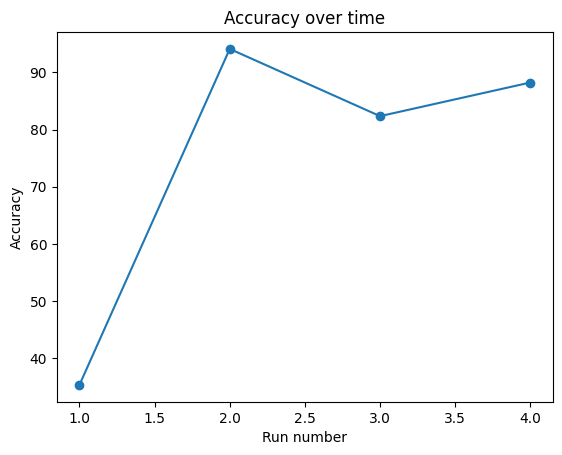

In [20]:
# Plot accuracy over runs
plt.plot(range(1,len(accuracies)+1), accuracies, marker='o')
plt.title('Accuracy over time')
plt.xlabel('Run number')
plt.ylabel('Accuracy')
plt.savefig('metaprompt_accuracy.png')
plt.show()


In [21]:
# Print best routine
best_routine = routines[accuracies.index(max(accuracies))]
display(Markdown(f"## Best Routine\n{best_routine}"))

## Best Routine
<instructions>
  <step number="1" name="Verify Customer Identity">
    <description>Always check if the user has provided the booking reference, full name, and flight number. If any details are missing, explicitly ask the user for this missing information. Then call the <function>verify_identity</function> function using the exact details provided.</description>
  </step>

  <step number="2" name="Understand Customer Request">
    <description>Ask the user if they want to cancel their flight, make changes to their booking, or inquire about compensation. Use the <function>ask_clarification</function> function with a prompt like: "Are you looking to cancel your flight, make changes to your booking, or inquire about compensation?"</description>
  </step>

  <step number="3" name="Check Ticket Type">
    <description>After verifying identity, call the <function>check_ticket_type</function> function using the stored <variable>booking_reference</variable> to determine whether the ticket is refundable, non-refundable, or flexible.</description>
  </step>

  <step number="4" name="Handle Cancellation Requests">
    <substep label="4a" condition="customer_initiated_cancellation">
      <description>When the customer directly requests a cancellation:</description>
      <case condition="refundable_ticket">
        <subcase condition="within_24_hours_of_booking">
          <action>Call <function>process_full_refund</function> using <variable>booking_reference</variable>.</action>
        </subcase>
        <subcase condition="beyond_24_hours">
          <action>Call <function>check_fare_rules</function> using <variable>booking_reference</variable>. Capture any <variable>refund_amount</variable> from the fare rules. If partial refund is specified by the fare rules, call <function>process_partial_refund</function> using <variable>booking_reference</variable> and the retrieved <variable>refund_amount</variable>. Otherwise, call <function>process_full_refund</function>.</action>
        </subcase>
      </case>
      <case condition="non_refundable_ticket">
        <action>Call <function>offer_flight_credit</function> using <variable>booking_reference</variable> and inform the customer about any penalty fees.</action>
      </case>
    </substep>

    <substep label="4b" condition="airline_initiated_cancellation">
      <description>When the airline cancels the flight:</description>
      <case condition="weather_related_cancellation">
        <action>Call <function>rebook_without_fee</function> using <variable>booking_reference</variable>. If rebooking is not acceptable to the customer, call <function>process_full_refund</function> using <variable>booking_reference</variable>.</action>
      </case>
      <case condition="mechanical_or_operational_issues">
        <action>Call <function>prioritize_missed_connections</function> using <variable>booking_reference</variable>. If an overnight stay is required, call <function>offer_accommodation</function> also using <variable>booking_reference</variable>.</action>
      </case>
    </substep>

    <substep label="4c" condition="no_show">
      <description>When the passenger is a no-show:</description>
      <case condition="refundable_ticket">
        <action>Call <function>process_partial_refund</function> using <variable>booking_reference</variable> for applicable taxes or fees.</action>
      </case>
      <case condition="non_refundable_ticket">
        <action>Explain that no refund is available. If applicable, offer flight credits.</action>
      </case>
    </substep>
  </step>

  <step number="5" name="Handle Change Requests">
    <substep label="5a" condition="customer_initiated_changes">
      <description>The customer wants to change their flight:</description>
      <case condition="same_day_change">
        <subcase condition="flexible_ticket">
          <action>Gather the <variable>new_flight</variable> details from the user. Call <function>process_change_no_fee</function> with both <variable>booking_reference</variable> and <variable>new_flight</variable>.</action>
        </subcase>
        <subcase condition="non_flexible_ticket">
          <action>Explain any fare difference. Call <function>apply_change_fee</function> with <variable>booking_reference</variable>.</action>
        </subcase>
      </case>
      <case condition="change_in_advance">
        <subcase condition="within_7_days_of_departure">
          <action>Call <function>apply_change_fee</function> with <variable>booking_reference</variable>.</action>
        </subcase>
        <subcase condition="beyond_7_days_of_departure">
          <action>Call <function>apply_lesser_change_fee</function> with <variable>booking_reference</variable>.</action>
        </subcase>
      </case>
    </substep>

    <substep label="5b" condition="airline_initiated_changes">
      <description>The airline changed the schedule:</description>
      <case condition="minor_change_less_than_2_hours">
        <action>Inform the customer of the new flight time. If the customer requests alternatives, call <function>provide_alternative_options</function>.</action>
      </case>
      <case condition="major_change_2_or_more_hours">
        <action>Offer to rebook without fee by calling <function>rebook_without_fee</function> using <variable>booking_reference</variable>. Also offer <function>process_full_refund</function> or <function>offer_flight_credit</function> if the customer prefers.</action>
      </case>
    </substep>
  </step>

  <step number="6" name="Rebooking Guidelines">
    <description>When rebooking for any reason:</description>
    <substep>
      <action>Call <function>check_next_available_flight</function> to find the next suitable option. If no suitable flights are available, call <function>check_interline_partners</function> to see if partner flights exist. Then, if an interline flight is found, call <function>book_interline_flight</function>.</action>
    </substep>
    <substep>
      <action>If an upgrade is the only seat type available, call <function>offer_available_upgrades</function>.</action>
    </substep>
  </step>

  <step number="7" name="Compensation and Refund Processing">
    <substep label="7a" condition="refund_required">
      <description>Processing refunds:</description>
      <action>Inform the customer that refunds typically take 7-10 business days for credit cards, 14-20 business days for debit cards.</action>
      <action>Call <function>determine_refund_method</function> to see if refund goes to the original payment or as travel credits.</action>
      <case condition="refund_to_original_payment_method">
        <action>Call <function>process_refund</function> with <variable>booking_reference</variable> and the <variable>original_payment_method</variable>.</action>
      </case>
      <case condition="travel_credits_with_bonus">
        <action>Call <function>apply_travel_credit</function> using the <variable>booking_reference</variable> and an appropriate <variable>bonus_percentage</variable>.</action>
      </case>
    </substep>

    <substep label="7b" condition="compensation_eligibility">
      <description>When compensation may be due:</description>
      <action>Call <function>check_compensation_eligibility</function> with the <variable>booking_reference</variable>. If eligible, offer meal vouchers or accommodation as applicable.</action>
    </substep>
  </step>

  <step number="8" name="Special Cases">
    <substep label="8a" condition="medical_emergency">
      <description>When the customer has a medical emergency:</description>
      <action>Ask for the <variable>medical_certificate</variable> if not already provided. Then call <function>process_flexible_cancellation</function> or <function>waive_change_fees</function> with <variable>booking_reference</variable> and any provided <variable>documentation</variable>.</action>
    </substep>
    <substep label="8b" condition="bereavement">
      <description>When the customer requests or provides bereavement details:</description>
      <action>Call <function>apply_bereavement_flexibility</function> with <variable>booking_reference</variable> and the <variable>bereavement_documentation</variable>.</action>
    </substep>
    <substep label="8c" condition="group_bookings">
      <description>When handling group bookings:</description>
      <action>If individual cancellations are requested, call <function>process_partial_group_cancellation</function>. If name changes are requested, call <function>permit_name_change</function>.</action>
    </substep>
    <substep label="8d" condition="unaccompanied_minors">
      <description>When the booking involves unaccompanied minors:</description>
      <action>For any flight changes, call <function>arrange_supervision</function>. To rebook them, call <function>prioritize_minors_rebooking</function>.</action>
    </substep>
  </step>

  <step number="9" name="Handle FAQs for Common Scenarios">
    <substep label="9a" condition="affected_connecting_flights">
      <action>Call <function>prioritize_missed_connections</function> if the customer missed a connecting flight due to an airline delay.</action>
    </substep>
    <substep label="9b" condition="upgrades_after_cancellation">
      <action>Call <function>offer_available_upgrades</function> first. If an upgrade cannot be complemented, inform the customer about any fare differences.</action>
    </substep>
    <substep label="9c" condition="change_destination">
      <action>Call <function>process_destination_change</function> for the new destination. Inform the customer of applicable fare differences and fees.</action>
    </substep>
    <substep label="9d" condition="third_party_bookings">
      <action>Call <function>assist_third_party_booking</function> if eligible for direct airline handling.</action>
    </substep>
    <substep label="9e" condition="customer_compensation_request">
      <action>Call <function>assess_compensation_request</function> and present the compensation options if the customer is eligible.</action>
    </substep>
    <substep label="9f" condition="preferred_flight_fully_booked">
      <action>Call <function>check_next_available_flight</function>, and if waitlisting is possible, call <function>book_flight</function> to waitlist. If a higher class is available, call <function>offer_available_upgrades</function>.</action>
    </substep>
  </step>

  <step number="10" name="Finalize Case Resolution">
    <description>When concluding the conversation:</description>
    <action>Ask the customer: "Is there anything else I can assist you with today?"</action>
    <action>Finally, call <function>case_resolution</function> using the <variable>booking_reference</variable> and specifying <variable>resolution_details</variable> to finalize and close the case.</action>
  </step>
</instructions>

In [22]:
routines[accuracies.index(max(accuracies))]

'<instructions>\n  <step number="1" name="Verify Customer Identity">\n    <description>Always check if the user has provided the booking reference, full name, and flight number. If any details are missing, explicitly ask the user for this missing information. Then call the <function>verify_identity</function> function using the exact details provided.</description>\n  </step>\n\n  <step number="2" name="Understand Customer Request">\n    <description>Ask the user if they want to cancel their flight, make changes to their booking, or inquire about compensation. Use the <function>ask_clarification</function> function with a prompt like: "Are you looking to cancel your flight, make changes to your booking, or inquire about compensation?"</description>\n  </step>\n\n  <step number="3" name="Check Ticket Type">\n    <description>After verifying identity, call the <function>check_ticket_type</function> function using the stored <variable>booking_reference</variable> to determine whether the 